# FinTech: Investment & Acquisition Prediction Model

*Techniques Used: Equity Valuation Metrics, ML Regression, ML Clustering*


--- Logistic Regression Report ---
[[0 1]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



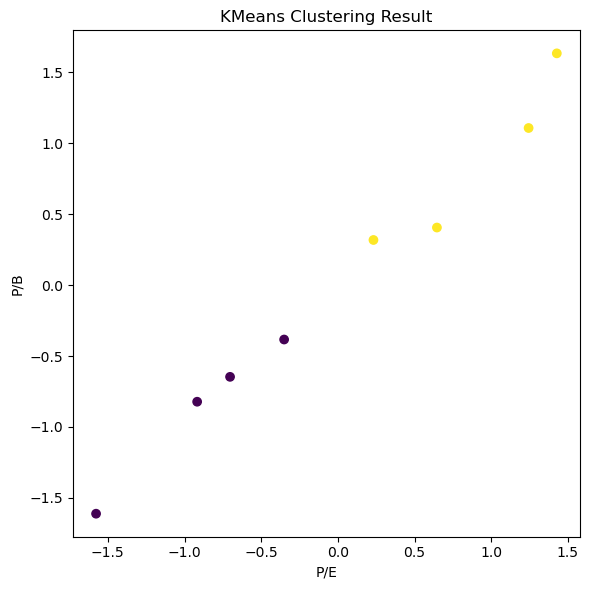

In [5]:
# -------------------------------
# Import of libraries
# -------------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = "1"  # Avoid KMeans + Windows MKL memory leak

# ----------------------------------------
# 1. Load or Create Dataset (Fallback)
# ----------------------------------------
csv_path = "financial_data.csv"

if not os.path.exists(csv_path):
    print("financial_data.csv not found. Creating fallback dataset.")
    fallback_data = {
        "P/E": [18.5, 22.3, 14.8, 30.1, 25.0, 10.5, 16.2, 28.9],
        "P/B": [3.2, 4.0, 2.7, 5.5, 4.1, 1.8, 2.9, 4.9],
        "PEG": [np.nan, 2.1, 1.0, 2.5, np.nan, 0.8, 1.3, np.nan],
        "DebtEquity": [0.5, 1.2, 0.7, 1.5, 0.9, 0.3, 0.6, 1.1],
        "ROE": [15.2, 18.5, 14.2, 22.1, 17.3, 12.4, 13.7, 21.4],
        "FreeCashflow": [1200000, 2500000, 900000, 3000000, 1800000, 700000, 1000000, 2200000],
    }
    pd.DataFrame(fallback_data).to_csv(csv_path, index=False)

# Load data
financial_df = pd.read_csv(csv_path)

# ----------------------------------------
# 2. Preprocessing
# ----------------------------------------
features = ["P/E", "P/B", "PEG", "DebtEquity", "ROE", "FreeCashflow"]

# Drop columns with all NaNs
for col in features:
    if financial_df[col].isna().all():
        print(f"Dropping column {col} (all NaN)")
        financial_df.drop(columns=[col], inplace=True)
        features.remove(col)

# Fill missing values
for col in features:
    if financial_df[col].isna().sum() > 0:
        if financial_df[col].isna().all():
            print(f"Filling column {col} with 0 (was all NaN)")
            financial_df[col] = 0
        else:
            financial_df[col].fillna(financial_df[col].median(), inplace=True)

# ----------------------------------------
# 3. Synthetic Acquisition Labeling
# ----------------------------------------
if "PEG" in financial_df.columns:
    financial_df["Acquisition_Label"] = (
        (financial_df["PEG"] < 1.5) & (financial_df["FreeCashflow"] > 0)
    ).astype(int)
else:
    financial_df["Acquisition_Label"] = 0  # fallback label if PEG not usable

# Save processed file
financial_df.to_csv("labeled_dataset.csv", index=False)

# ----------------------------------------
# 4. Regression - Logistic Model
# ----------------------------------------
X = financial_df[features]
y = financial_df["Acquisition_Label"]

if len(y.unique()) < 2 or y.value_counts().min() < 2:
    print("Insufficient class variety in labels to train model.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_model = LogisticRegression()
    log_model.fit(X_train_scaled, y_train)
    y_pred = log_model.predict(X_test_scaled)

    print("\n--- Logistic Regression Report ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

# ----------------------------------------
# 5. ML Clustering - KMeans
# ----------------------------------------
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled_full)
financial_df["Cluster"] = clusters

# Plot and export
plt.figure(figsize=(6, 6))
plt.scatter(X_scaled_full[:, 0], X_scaled_full[:, 1], c=clusters, cmap='viridis')
plt.title("KMeans Clustering Result")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.tight_layout()
plt.savefig("kmeans_cluster_plot.png")
plt.show()

# Save final dataset with clusters
financial_df.to_csv("final_clustered_data.csv", index=False)